In [1]:
import re
import yaml
import json
import string
import demjson
import pandas as pd
import numpy as np
from numpy import loadtxt
from tqdm import tqdm
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import ToktokTokenizer
from nltk.corpus import wordnet
import tensorflow as tf
from src.datapipeline_6estate import DataPipeline, Model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AutoConfig
from langdetect import detect
import transformers
# auto reload modules
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)

C:\Users\kewen\Anaconda3\envs\x-train\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\kewen\Anaconda3\envs\x-train\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\kewen\Anaconda3\envs\x-train\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kewen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# load in the data
train = pd.DataFrame([demjson.decode(line) for line in open('data/train.json', 'r')])
val = pd.DataFrame([demjson.decode(line) for line in open('data/dev.json', 'r')])
test = pd.DataFrame([demjson.decode(line) for line in open('data/test.json', 'r')])

display("train:", train.head())
display("val:", val.head())
display("test:", test.head())

'train:'

,label,sentence
0,1,"it's all stitched together with energy , intelligence and verve , enhanced by a surplus of vintage archive footage ."
1,0,"because of an unnecessary and clumsy last scene , 'swimfan' left me with a very bad feeling ."
2,0,the stories here suffer from the chosen format .
3,1,it turns out to be smarter and more diabolical than you could have guessed at the beginning .
4,0,"all of the elements are in place for a great film noir , but director george hickenlooper's approach to the material is too upbeat ."


'val:'

,label,sentence
0,0,the colorful masseur wastes its time on mood rather than riding with the inherent absurdity of ganesh's rise up the social ladder .
1,0,"a timid , soggy near miss ."
2,0,going to the website may be just as fun ( and scary ) as going to the film .
3,1,"nervy and sensitive , it taps into genuine artistic befuddlement , and at the same time presents a scathing indictment of what drives hollywood ."
4,1,"it may not be a huge cut of above the rest , but i enjoyed barbershop . it's a funny little movie with clever dialogue and likeable characters ."


'test:'

,label,sentence
0,0,"the direction , by george hickenlooper , has no snap to it , no wiseacre crackle or hard-bitten cynicism ."
1,0,barry sonnenfeld owes frank the pug big time
2,1,"if this movie were a book , it would be a page-turner , you can't wait to see what happens next ."
3,0,"[garbus] discards the potential for pathological study , exhuming instead , the skewed melodrama of the circumstantial situation ."
4,1,not too far below the gloss you can still feel director denis villeneuve's beating heart and the fondness he has for his characters .


# <font color="green"> EDA

In [3]:
train.shape

(8636, 2)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8636 entries, 0 to 8635
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     8636 non-null   int64 
 1   sentence  8636 non-null   object
dtypes: int64(1), object(1)
memory usage: 135.1+ KB


In [5]:
train.label.value_counts()

1    4318
0    4318
Name: label, dtype: int64

In [6]:
# the class labels are quite balanced

In [7]:
train.sentence.apply(lambda x: len(x)).describe()

count    8636.000000
mean      115.285665
std        51.051265
min         5.000000
25%        77.000000
50%       112.000000
75%       150.000000
max       268.000000
Name: sentence, dtype: float64

In [8]:
# most of the sentences have length around 110 words, which is not so length, so we can just apply truncate when training models

In [9]:
val.shape

(960, 2)

In [10]:
test.shape

(1066, 2)

In [11]:
val.label.value_counts()

1    480
0    480
Name: label, dtype: int64

In [12]:
test.label.value_counts()

1    533
0    533
Name: label, dtype: int64

In [13]:
# the data was nicely prepared, so we don't have to consider imbalance class problem, accuracy can be used for evaluation

In [14]:
train.sentence.duplicated().any(axis=0)

False

In [15]:
test.sentence.duplicated().any(axis=0)

False

In [16]:
val.sentence.duplicated().any(axis=0)

False

In [17]:
# seems no duplicates in terms of sentences

In [18]:
train.isnull().any(axis=0)

label       False
sentence    False
dtype: bool

In [19]:
test.isnull().any(axis=0)

label       False
sentence    False
dtype: bool

In [20]:
val.isnull().any(axis=0)

label       False
sentence    False
dtype: bool

In [21]:
# no missing value found also

# <font color="green"> Data Cleaning

In [22]:
# random choose some samples to examine
train.sample(20)

,label,sentence
7854,1,"ambitious , unsettling psychodrama that takes full , chilling advantage of its rough-around-the-edges , low-budget constraints ."
4088,1,star/producer salma hayek and director julie taymor have infused frida with a visual style unique and inherent to the titular character's paintings and in the process created a masterful work of art of their own .
2208,1,"the film fearlessly gets under the skin of the people involved . . . this makes it not only a detailed historical document , but an engaging and moving portrait of a subculture ."
6144,0,"first good , then bothersome . excellent acting and direction ."
6811,0,nervous breakdowns are not entertaining .
2554,1,"terrific as nadia , a russian mail-order bride who comes to america speaking not a word of english , it's kidman who holds the film together with a supremely kittenish performance that gradually accumulates more layers ."
8177,0,all this turns out to be neither funny nor provocative - only dull .
4269,1,a weird and wonderful comedy .
7911,0,has all the complexity and realistic human behavior of an episode of general hospital .
7114,1,"if anything , the film is doing something of a public service -- shedding light on a group of extremely talented musicians who might otherwise go unnoticed and underappreciated by music fans ."


In [23]:
# remove non-English examples

In [24]:
non_English = train[train.sentence.apply(lambda x: detect(x)) != "en"]

In [25]:
# not all the results are non-English, so we need to manually filter it
non_English

,label,sentence
102,1,'interesante y disfrutable trabajo gracias a que prescinde del clsico elemento estadounidense patriotero y manipulador . '
167,0,a bravura exercise in emptiness .
181,0,"no dia em que aceitou dirigir esta continuao , harold ramis deve ter sado da cama com o p esquerdo . e aqueles que decidiram assistir a este filme tambm ."
186,1,an escapist confection that's pure entertainment .
213,1,touch !
301,0,"'es en verdad una pena que mandoki est realizando cintas tan malas desde hace algn tiempo , pues talento tiene , pero quin sabe dnde lo tiene escondido . '"
372,0,extremely bad .
373,0,cinematic poo .
432,1,ahhhh . . . revenge is sweet !
454,1,a true pleasure .


In [26]:
# need visually check which one is really non-English

In [27]:
# prepare the drop list based on eyeballing checks
drop_list = [102, 181, 301, 521, 587, 694, 883, 1186, 1273, 1462, 1682, 2025, 2367, 2578, 3064, 3349, 3579, 3820, 3822, 3892, 3894, 3896, 4145, 4195, 4260, 4326, 4372, 4377, 4646, 4750, 4796, 4803, 4916, 4931, 5496, 5686, 5973, 6112, 6178, 6245, 6354, 6414, 6449, 6636, 6764, 6944, 7334, 7432, 7498, 7842, 8388]

In [28]:
# now we are very sure those 51 examples are not in English 
train.iloc[drop_list, :]

,label,sentence
102,1,'interesante y disfrutable trabajo gracias a que prescinde del clsico elemento estadounidense patriotero y manipulador . '
181,0,"no dia em que aceitou dirigir esta continuao , harold ramis deve ter sado da cama com o p esquerdo . e aqueles que decidiram assistir a este filme tambm ."
301,0,"'es en verdad una pena que mandoki est realizando cintas tan malas desde hace algn tiempo , pues talento tiene , pero quin sabe dnde lo tiene escondido . '"
521,1,ns gosta muito de as duas torres .
587,1,"el ttulo no engaa : la pelcula narra una historia donde una mujer enfrentar cierta realidad , y donde el sexo es . . ."
694,1,"uma pena que , mais tarde , o prprio filme abandone o tom de pardia e passe a utilizar os mesmos clichs que havia satirizado ."
883,1,"apesar de seus graves problemas , o filme consegue entreter ."
1186,1,"en s mismo el rey len es un espectculo digno de contemplarse en cine , dvd o en su soberbio montaje teatral ; pero el hacerlo en la pantalla imax es una experiencia colosal ."
1273,1,"es una de esas pelculas de las que uno sale reconfortado , agradecido , genuinamente sorprendido ."
1462,1,"chicago pode at ser um filme divertido e cativante ( como ) , mas acaba representando um passo que vai na direo contrria evoluo dos musicais ."


In [29]:
len(drop_list)

51

In [30]:
# sanity check
8585 + 51

8636

In [31]:
# update train set
train = train.drop(drop_list, axis=0)

In [32]:
train.shape

(8585, 2)

# <font color="green"> Try TF-IDF Model As Benchmark

In [33]:
train_bow = train.copy()
test_bow = test.copy()
val_bow = val.copy()

In [34]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [35]:
lemmatizer = WordNetLemmatizer()

In [36]:
def Lemmatization(lemmatizer, sentence):
    lemma_sentence=[]
    for word in sentence:
        lemma_sentence.append(lemmatizer.lemmatize(word, pos=get_wordnet_pos(word))) # need long time to run
        #lemma_sentence.append(lemmatizer.lemmatize(word))
        lemma_sentence.append(" ")
    return "".join(lemma_sentence)

In [37]:
def expand_contractions(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [38]:
def tokenize(text):
            
    # remove special characters
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    processed_text = re.sub(pat, '', text)
    
    # remove digits
    pattern = '[0-9]'
    processed_text = re.sub(pattern, '', processed_text)

    # remove punctuations
    processed_text = ''.join([c for c in processed_text if c not in string.punctuation])
    
    # remove extra white spaces and tabs
    pattern = r'^\s*|\s\s*'
    processed_text = re.sub(pattern, ' ', processed_text).strip()
    
    # convert to lower case
    processed_text = processed_text.lower()
    
    # expand contractions
    processed_text = expand_contractions(processed_text)
    
    # tokenization 
    tokenizer = ToktokTokenizer()
    token_words = tokenizer.tokenize(processed_text)

    # lemmatization
    processed_text = Lemmatization(lemmatizer, token_words)
    
    # remove stop words
    stopword_list = nltk.corpus.stopwords.words('english')
    stopword_list.remove('not')
    tokens = tokenizer.tokenize(processed_text)
    tokens = [token.strip() for token in tokens]
    t = [token for token in tokens if token.lower() not in stopword_list]
    
    # join the list elements back to string
    processed_text = ' '.join(t)
    return processed_text

In [39]:
tqdm.pandas()

In [40]:
train_bow.loc[:, "sentence"] = train_bow.sentence.progress_apply(lambda x: tokenize(x))

100%|███████████████████████████████████████████████████████████████████████████████████████████| 8585/8585 [01:48<00:00, 78.93it/s]


In [41]:
test_bow.loc[:, "sentence"] = test_bow.sentence.progress_apply(lambda x: tokenize(x))

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1066/1066 [00:12<00:00, 82.91it/s]


In [42]:
val_bow.loc[:, "sentence"] = val_bow.sentence.progress_apply(lambda x: tokenize(x))

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 960/960 [00:11<00:00, 85.45it/s]


In [43]:
train_combined = pd.concat([train_bow, val_bow])

In [44]:
tf_idf = TfidfVectorizer(tokenizer=tokenize, analyzer="word", min_df=10, max_df=0.8, lowercase=False)

In [45]:
# Logistic regression 
logistic = LogisticRegressionCV(penalty='l2', max_iter=5000, random_state=1, cv=10)

# sklearn Pipeline
pipe = Pipeline(steps=[
    ('tf-idf', tf_idf),
    ('logistic regression', logistic)])

results = pipe.fit(train_combined['sentence'], train_combined["label"])

test_prediction = pipe.predict(test_bow['sentence'])
display(f'Logistic Regression Acc: {accuracy_score(test_prediction, test_bow["label"]) * 100:.2f}%')

'Logistic Regression Acc: 50.38%'

In [46]:
# Random Forest classifier
clf = RandomForestClassifier(random_state=1)

# Pipeline
pipe = Pipeline(steps=[
    ('tf-idf', tf_idf),
    ('RF', clf)])

results = pipe.fit(train_combined['sentence'], train_combined["label"])

test_prediction = pipe.predict(test_bow['sentence'])
display(f'Random Forest Acc: {accuracy_score(test_prediction, test_bow["label"]) * 100:.2f}%')

'Random Forest Acc: 50.84%'

# <font color="green"> Prediction Result Analysis

In [47]:
history = pd.read_csv("./model/history.csv") 

In [48]:
history

,loss,binary_accuracy,val_loss,val_binary_accuracy,lr
0,0.435763,0.791278,0.351411,0.849330,0.000050
1,0.223348,0.914627,0.326201,0.870536,0.000050
2,0.118646,0.959324,0.442864,0.850446,0.000050
3,0.050684,0.984037,0.543178,0.849330,0.000050
4,0.045392,0.985456,0.555511,0.866071,0.000050
5,0.026460,0.991132,0.627179,0.862723,0.000050
6,0.019876,0.993497,0.696384,0.861607,0.000050
7,0.012880,0.995388,0.721866,0.861607,0.000050
8,0.013904,0.994679,0.793581,0.854911,0.000045
9,0.007072,0.997872,0.785277,0.862723,0.000045


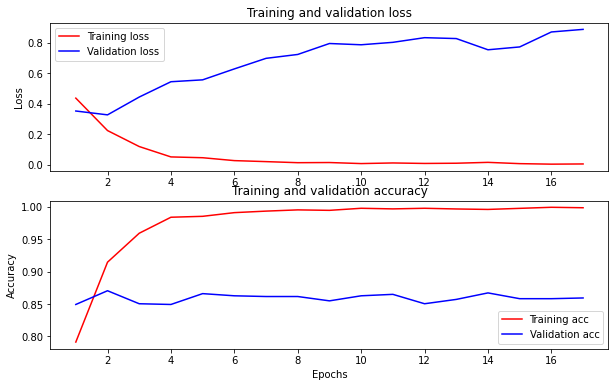

In [49]:
acc = history['binary_accuracy']
val_acc = history['val_binary_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# <font color="green"> Model Inference

In [50]:
# disable GPU to run bert base as my gpu is very small and always get out of memory
try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [51]:
# prepare the tensorflow dataset
dp = DataPipeline()
train = dp.transform_data("data/train.json")
drop_list = [102, 181, 301, 521, 587, 694, 883, 1186, 1273, 1462, 1682, 2025, 2367, 2578, 3064, 3349, 3579, 3820, 3822, 3892, 3894, 3896, 4145, 4195, 4260, 4326, 4372, 4377, 4646, 4750, 4796, 4803, 4916, 4931, 5496, 5686, 5973, 6112, 6178, 6245, 6354, 6414, 6449, 6636, 6764, 6944, 7334, 7432, 7498, 7842, 8388]
train = train.drop(drop_list, axis=0)
val = dp.transform_data("data/dev.json")
test = dp.transform_data("data/test.json")
with open("./src/config_6estate.yml") as file:
    config = yaml.safe_load(file)
model = Model(config, "./model")
train_dataset, test_dataset, validation_dataset = model.preprocess_data(train, val, test)

INFO:6estates:Datapipeline is initiated
INFO:6estates:performed dropping missing values
INFO:6estates:performed dropping duplicates
INFO:6estates:finished transforming data
INFO:6estates:performed dropping missing values
INFO:6estates:performed dropping duplicates
INFO:6estates:finished transforming data
INFO:6estates:performed dropping missing values
INFO:6estates:performed dropping duplicates
INFO:6estates:finished transforming data
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:6estates:initiating model


In [52]:
# load in the trained model
trained_model = TFAutoModelForSequenceClassification.from_pretrained('./model')  

Some layers from the model checkpoint at ./model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [53]:
trained_model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_75 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  769       
Total params: 109,483,009
Trainable params: 109,483,009
Non-trainable params: 0
_________________________________________________________________


In [54]:
# the logits from dense layer
predicted_logits = trained_model.predict(test_dataset)["logits"]

predicted_logits

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x000001F7C90A7688> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).WARNING:tensorflow:AutoGraph could not transform <bound method Socket.send of <zmq.sugar.socket.Socket object at 0x000001F7C7A34B40>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x000001F7C90A7688> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x000001F7C90A7688> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert



The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


array([[-2.9258776 ],
       [-0.40722215],
       [ 1.1818095 ],
       ...,
       [-4.1643167 ],
       [ 0.33232036],
       [ 1.5001366 ]], dtype=float32)

In [55]:
# predicted labels
predicted_labels = [int(i) for i in tf.round(tf.sigmoid(predicted_logits)).numpy()]
predicted_labels

[0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,


In [56]:
# true labels
true_labels = test["label"].tolist()
true_labels

[0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,


In [57]:
# method 1 - by tensorflow binary accuray(which is the same as the model.evaluate)
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(predicted_labels,true_labels)
display(f"Fine Tuned BERT Acc: {m.result().numpy()}")

'Fine Tuned BERT Acc: 0.8827391862869263'

In [58]:
# method 2 - by sklearn accuracy_score
display(f'Fine Tuned BERT Acc: {accuracy_score(predicted_labels, true_labels):.2f}')

'Fine Tuned BERT Acc: 0.88'

In [59]:
# method 3 - by the files generated directly during model training
predicted_labels = pd.read_csv("./model/predicted.csv", header=None)
display(f'Fine Tuned BERT Acc: {accuracy_score(predicted_labels, true_labels):.2f}')

'Fine Tuned BERT Acc: 0.88'

### plot confusion matrix

In [60]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(classes)-0.5)
    plt.ylim(len(np.unique(classes))-0.5, -0.5)
    return ax

Confusion matrix, without normalization
[[461  72]
 [ 53 480]]


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

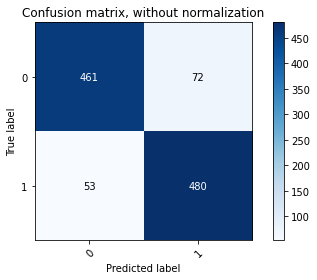

In [61]:
plot_confusion_matrix(true_labels, predicted_labels, np.unique(test["label"])) 

In [62]:
recall = recall_score(true_labels, predicted_labels)
recall

0.900562851782364

In [63]:
precision = precision_score(true_labels, predicted_labels)
precision

0.8695652173913043

In [64]:
# recall and precision are quite similar to the accuracy